In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm

# FDTD (Finite-Difference Time-Domain)

Written by Lawson Fuller, 5/5/2024, with accelerated code-writing assistance from GPT-4.

<!-- Algorithm based on this resource:
https://www.oceanopticsbook.info/view/theory-electromagnetism/level-2/maxwells-equations-matter

$$
\begin{align}
    \nabla \cdot \mathbf{D} &= \rho_f & \text{(Gauss's law for electric field)} \\
    \nabla \cdot \mathbf{B} &= 0 & \text{(Gauss's law for magnetic field)} \nonumber\\
    \nabla \times \mathbf{E} &= -\frac{\partial \mathbf{B}}{\partial t} & \text{(Maxwell-Faraday equation)} \nonumber\\
    \nabla \times \mathbf{B} &= \mu_0\mathbf{J} + \mu_0\varepsilon_0\frac{\partial \mathbf{E}}{\partial t} & \text{(Ampère-Maxwell law)} \nonumber
\end{align}
$$ -->

My simulation approach is based on this resource:
https://empossible.net/wp-content/uploads/2019/08/Lecture-5a-Finite-Difference-Time-Domain.pdf

I'll simulate in 3-D but assume linear, time-independent, and isotropic material.

Note that for more numerical stability, it is better to make E and H similar orders of magnitude by "normalizing" units. I don't do this for simplicity. 

The dynamical equations for the fields are (SI conventions):
$$
\begin{align}
    \nabla \times \mathbf{E} &= -\frac{\partial \mathbf{B}}{\partial t}, &\text{(Faraday's Law of Induction)} \\
    \mathbf{B}(t) &= \mu \mathbf{H}(t), &\text{(Definition of Magnetic Flux Density)} \\
    \nabla \times \mathbf{H} &= \frac{\partial \mathbf{D}}{\partial t}, &\text{(Ampère's Law with Maxwell's Addition)} \\
    \mathbf{D}(t) &= \epsilon \mathbf{E}(t), &\text{(Definition of Electric Displacement Field)}
\end{align}
$$
where $\mu$ and $\epsilon$ depend on the material.
From substituting the constitutive relations D(E) and H(B), we concisely arrive at:
$$
\begin{align}
    \nabla \times \mathbf{E} &= -\mu\frac{\partial \mathbf{H}}{\partial t}, &\text{(Faraday's Law of Induction)} \\
    \nabla \times \mathbf{H} &= \epsilon\frac{\partial \mathbf{E}}{\partial t}, &\text{(Ampère's Law with Maxwell's Addition)} \\
\end{align}
$$

A numerical approximation of these dynamical equations as a function of time is:

Electric Field Update Equation (component i at grid point (i,j,k))
$$
\begin{equation}
\mathbf{E_i}^{(i,j,k)}(t + \Delta t) = \mathbf{E_i}^{(i,j,k)}(t) + \frac{\Delta t}{\epsilon^{(i,j,k)}} \left( (\nabla \times \mathbf{H})_i^{(i,j,k)}(t + \frac{\Delta t}{2}) - \sigma^{(i,j,k)} \mathbf{E}_i^{(i,j,k)}(t) \right)
\end{equation}
$$
Magnetic Field Update Equation
$$
\begin{equation}
\mathbf{H_i}^{(i,j,k)}(t + \frac{\Delta t}{2}) = \mathbf{H_i}^{(i,j,k)}(t - \frac{\Delta t}{2}) - \frac{\Delta t}{\mu^{(i,j,k)}} \cdot (\nabla \times \mathbf{E})_i^{(i,j,k)}(t)
\end{equation}
$$
E and H timesteps are staggered for numerical instability. To approximate H at integer timesteps (same times as E), interpolate between the existing solutions of H at solved half-integer timesteps.

We can conveniently use a Yee grid for the curl calculations because the H and E values are staggered (as with the time) in a way that lets the calculations remain stable. See this video resource, which is connected to the prior "EMPossible" resource, that my calculations are based on, for more information:
https://www.youtube.com/watch?v=sxv_L4rscL0&list=PLLYQF5WvJdJWoU9uEeWJ6-MRzDSziNnGt&index=6

Note that in a Yee grid, the 3 components of $\mathbf{E}^{(i,j,k)}$ or of $\mathbf{H}^{(i,j,k)}$ are at different locations (x,y,z). For example, $\mathbf{H}_x^{(i,j,k)}$ is actually at a different location than $\mathbf{H}_y^{(i,j,k)}$.

### Curls of E

$$
\begin{align}
(\nabla \times \mathbf{E})_x^{(i,j,k)} &= \frac{\partial \mathbf{E}_z^{(i,j,k)}}{\partial y} - \frac{\partial \mathbf{E}_y^{(i,j,k)}}{\partial z} \\
&\approx \frac{\mathbf{E}_z^{(i,j+1,k)} - \mathbf{E}_z^{(i,j,k)}}{\Delta y} - \frac{\mathbf{E}_y^{(i,j,k+1)}-\mathbf{E}_y^{(i,j,k)}}{\Delta z}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{E})_y^{(i,j,k)} &= \frac{\partial \mathbf{E}_x^{(i,j,k)}}{\partial z} - \frac{\partial \mathbf{E}_z^{(i,j,k)}}{\partial x} \\
&\approx \frac{\mathbf{E}_x^{(i,j,k+1)} - \mathbf{E}_x^{(i,j,k)}}{\Delta z} - \frac{\mathbf{E}_z^{(i+1,j,k)}-\mathbf{E}_z^{(i,j,k)}}{\Delta x}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{E})_z^{(i,j,k)} &= \frac{\partial \mathbf{E}_y^{(i,j,k)}}{\partial x} - \frac{\partial \mathbf{E}_x^{(i,j,k)}}{\partial y} \\
&\approx \frac{\mathbf{E}_y^{(i+1,j,k)} - \mathbf{E}_y^{(i,j,k)}}{\Delta x} - \frac{\mathbf{E}_x^{(i,j+1,k)}-\mathbf{E}_x^{(i,j,k)}}{\Delta y}
\end{align}
$$

### Curls of H

$$
\begin{align}
(\nabla \times \mathbf{H})_x^{(i,j,k)} &= \frac{\partial \mathbf{H}_z^{(i,j,k)}}{\partial y} - \frac{\partial \mathbf{H}_y^{(i,j,k)}}{\partial z} \\
&\approx \frac{\mathbf{H}_z^{(i,j,k)} - \mathbf{H}_z^{(i,j-1,k)}}{\Delta y} - \frac{\mathbf{H}_y^{(i,j,k)}-\mathbf{H}_y^{(i,j,k-1)}}{\Delta z}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{H})_y^{(i,j,k)} &= \frac{\partial \mathbf{H}_x^{(i,j,k)}}{\partial z} - \frac{\partial \mathbf{H}_z^{(i,j,k)}}{\partial x} \\
&\approx \frac{\mathbf{H}_x^{(i,j,k)} - \mathbf{H}_x^{(i,j,k-1)}}{\Delta z} - \frac{\mathbf{H}_z^{(i,j,k)}-\mathbf{H}_z^{(i-1,j,k)}}{\Delta x}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{H})_z^{(i,j,k)} &= \frac{\partial \mathbf{H}_y^{(i,j,k)}}{\partial x} - \frac{\partial \mathbf{H}_x^{(i,j,k)}}{\partial y} \\
&\approx \frac{\mathbf{H}_y^{(i,j,k)} - \mathbf{H}_y^{(i-1,j,k)}}{\Delta x} - \frac{\mathbf{H}_x^{(i,j,k)}-\mathbf{H}_x^{(i,j-1,k)}}{\Delta y}
\end{align}
$$

## Define space arrays

In [2]:
# Define spaces
def cubic_space_xyz(N, length=1.0):
    """
    Generate a cubic space represented by 3D meshgrids, with specific orientation suitable for plotting and analysis. 
    The function creates three-dimensional arrays for X, Y, and Z coordinates, where X is aligned along the horizontal 
    axis (columns vary), and Y is aligned along the vertical axis (rows vary). This is typically used for initializing 
    the spatial grid for numerical simulations where the conventional x-y Cartesian plane orientation is preferred.

    Parameters:
        N (int): The number of points along each axis, which defines the resolution of the grid. A higher number 
                 results in a finer grid.
        length (float): The total length of each axis in the space, from 0 to 'length'. This allows scaling the grid 
                        to the size of the physical or simulation domain. Default is 1.0, creating a unit cube grid.

    Returns:
        tuple of np.ndarray: Three 3D arrays (X, Y, Z) representing the grid coordinates with shape (N, N, N) each. 
                             These arrays form a structured grid where each array contains the coordinates for one 
                             dimension across the entire grid.
    """
    points = np.linspace(0, length, N)
    X, Y, Z = np.meshgrid(points, points, points, indexing='ij')
    return X, Y, Z

## Define spatially-varying material constants (time independence and isotropy assumed)

In [3]:
def initialize_epsilon(X, Y, Z, base_epsilon, variation_func=None):
    """
    Initialize the spatial distribution of the permittivity tensor across the simulation grid.
    Assuming isotropic epsilon, which can vary on (x,y,z)
    
    Parameters:
        X, Y, Z (np.ndarray): 3D arrays representing the grid coordinates in each spatial dimension.
        base_epsilon (float): Base value of permittivity for the medium.
        variation_func (callable, optional): Function to apply spatial variation to permittivity. 
                                             Should accept X, Y, Z as arguments and return an array of the same shape.
    
    Returns:
        np.ndarray: 3D array representing the spatial distribution of permittivity.
    """
    epsilon = np.full_like(X, base_epsilon)
    if variation_func:
        epsilon += variation_func(X, Y, Z)
    return epsilon

def initialize_mu(X, Y, Z, base_mu, variation_func=None):
    """
    Initialize the spatial distribution of the permeability tensor across the simulation grid.
    Assuming isotropic mu, which can vary on (x,y,z)

    Parameters:
        X, Y, Z (np.ndarray): 3D arrays representing the grid coordinates in each spatial dimension.
        base_mu (float): Base value of permeability for the medium.
        variation_func (callable, optional): Function to apply spatial variation to permeability. 
                                             Should accept X, Y, Z as arguments and return an array of the same shape.
    
    Returns:
        np.ndarray: 3D array representing the spatial distribution of permeability.
    """
    mu = np.full_like(X, base_mu)
    if variation_func:
        mu += variation_func(X, Y, Z)
    return mu

def initialize_sigma(X, Y, Z, base_sigma, variation_func=None):
    """
    Initialize the spatial distribution of the conductivity tensor across the simulation grid.
    Assuming isotropic sigma, which can vary on (x,y,z)

    Parameters:
        X, Y, Z (np.ndarray): 3D arrays representing the grid coordinates in each spatial dimension.
        base_sigma (float): Base value of conductivity for the medium.
        variation_func (callable, optional): Function to apply spatial variation to conductivity. 
                                             Should accept X, Y, Z as arguments and return an array of the same shape.
    
    Returns:
        np.ndarray: 3D array representing the spatial distribution of conductivity.
    """
    sigma = np.full_like(X, base_sigma)
    if variation_func:
        sigma += variation_func(X, Y, Z)
    return sigma

def plot_material_properties(X, Y, epsilon, mu, slice_index=0):
    """
    Plot the permittivity and permeability for a given slice index in the Z-direction.

    Parameters:
        X, Y: 2D arrays of the grid coordinates in the x and y directions.
        epsilon, mu: 3D arrays of the material properties.
        slice_index: Integer index of the Z slice to be plotted.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot permittivity
    c1 = ax1.contourf(X[:, :, slice_index], Y[:, :, slice_index], epsilon[:, :, slice_index], levels=50, cmap='viridis')
    fig.colorbar(c1, ax=ax1)
    ax1.set_title('Permittivity (ε) at Slice Z-index= {}'.format(slice_index))
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # Plot permeability
    c2 = ax2.contourf(X[:, :, slice_index], Y[:, :, slice_index], mu[:, :, slice_index], levels=50, cmap='magma')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title('Permeability (μ) at Slice Z-index= {}'.format(slice_index))
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    plt.tight_layout()
    plt.show()

## Define field arrays

In [4]:
def initialize_E_field(X, Y, Z):
    """
    Initialize the electric field components for an FDTD simulation grid at time 0.
    This example initializes the field with a simple Gaussian distribution for Ex,
    centered in the domain with zero initial conditions for Ey and Ez.

    Parameters:
        X, Y, Z (np.ndarray): 3D arrays representing the grid coordinates in each spatial dimension.

    Returns:
        array of np.ndarray: Three 3D arrays (Ex, Ey, Ez) representing the initialized electric field components.
    """
    Ex = np.zeros_like(X) #np.exp(-((X - 0.5)**2 + (Y - 0.5)**2 + (Z - 0.5)**2) / 0.01)
    Ey = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2 + (Z - 0.5)**2) / 0.01) # np.zeros_like(X) # + np.sin(omega*t-beta*Z)
    Ez = np.zeros_like(X)
    return np.array([Ex, Ey, Ez])

def initialize_H_field(X, Y, Z):
    """
    Initialize the magnetic field components for an FDTD simulation grid at time 0-1/(Delta t).
    This example initializes all components (Hx, Hy, Hz) to zero, which is common
    for starting conditions in many scenarios.

    Parameters:
        X, Y, Z (np.ndarray): 3D arrays representing the grid coordinates in each spatial dimension.

    Returns:
        array of np.ndarray: Three 3D arrays (Hx, Hy, Hz) representing the initialized magnetic field components.
    """
    Hx = np.zeros_like(X)
    Hy = np.zeros_like(X)
    Hz = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2 + (Z - 0.5)**2) / 0.01) #np.zeros_like(X)
    return np.array([Hx, Hy, Hz])

def calculate_D_field(E, epsilon):
    # Requires E to calculate
    return np.multiply(epsilon[np.newaxis,:], E)

def calculate_B_field(H, mu):
    # Requires H to calculate
    return np.multiply(mu[np.newaxis,:], H)

## Field update equations

Electric Field Update Equation (component i at grid point (i,j,k))
$$
\begin{equation}
\mathbf{E_i}^{(i,j,k)}(t + \Delta t) = \mathbf{E_i}^{(i,j,k)}(t) + \frac{\Delta t}{\epsilon^{(i,j,k)}} \left( (\nabla \times \mathbf{H})_i^{(i,j,k)}(t + \frac{\Delta t}{2}) - \sigma^{(i,j,k)} \mathbf{E}_i^{(i,j,k)}(t) \right)
\end{equation}
$$
Magnetic Field Update Equation
$$
\begin{equation}
\mathbf{H_i}^{(i,j,k)}(t + \frac{\Delta t}{2}) = \mathbf{H_i}^{(i,j,k)}(t - \frac{\Delta t}{2}) - \frac{\Delta t}{\mu^{(i,j,k)}} \cdot (\nabla \times \mathbf{E})_i^{(i,j,k)}(t)
\end{equation}
$$

where:

### Curls of E

$$
\begin{align}
(\nabla \times \mathbf{E})_x^{(i,j,k)} &= \frac{\partial \mathbf{E}_z^{(i,j,k)}}{\partial y} - \frac{\partial \mathbf{E}_y^{(i,j,k)}}{\partial z} \\
&\approx \frac{\mathbf{E}_z^{(i,j+1,k)} - \mathbf{E}_z^{(i,j,k)}}{\Delta y} - \frac{\mathbf{E}_y^{(i,j,k+1)}-\mathbf{E}_y^{(i,j,k)}}{\Delta z}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{E})_y^{(i,j,k)} &= \frac{\partial \mathbf{E}_x^{(i,j,k)}}{\partial z} - \frac{\partial \mathbf{E}_z^{(i,j,k)}}{\partial x} \\
&\approx \frac{\mathbf{E}_x^{(i,j,k+1)} - \mathbf{E}_x^{(i,j,k)}}{\Delta z} - \frac{\mathbf{E}_z^{(i+1,j,k)}-\mathbf{E}_z^{(i,j,k)}}{\Delta x}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{E})_z^{(i,j,k)} &= \frac{\partial \mathbf{E}_y^{(i,j,k)}}{\partial x} - \frac{\partial \mathbf{E}_x^{(i,j,k)}}{\partial y} \\
&\approx \frac{\mathbf{E}_y^{(i+1,j,k)} - \mathbf{E}_y^{(i,j,k)}}{\Delta x} - \frac{\mathbf{E}_x^{(i,j+1,k)}-\mathbf{E}_x^{(i,j,k)}}{\Delta y}
\end{align}
$$

### Curls of H

$$
\begin{align}
(\nabla \times \mathbf{H})_x^{(i,j,k)} &= \frac{\partial \mathbf{H}_z^{(i,j,k)}}{\partial y} - \frac{\partial \mathbf{H}_y^{(i,j,k)}}{\partial z} \\
&\approx \frac{\mathbf{H}_z^{(i,j,k)} - \mathbf{H}_z^{(i,j-1,k)}}{\Delta y} - \frac{\mathbf{H}_y^{(i,j,k)}-\mathbf{H}_y^{(i,j,k-1)}}{\Delta z}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{H})_y^{(i,j,k)} &= \frac{\partial \mathbf{H}_x^{(i,j,k)}}{\partial z} - \frac{\partial \mathbf{H}_z^{(i,j,k)}}{\partial x} \\
&\approx \frac{\mathbf{H}_x^{(i,j,k)} - \mathbf{H}_x^{(i,j,k-1)}}{\Delta z} - \frac{\mathbf{H}_z^{(i,j,k)}-\mathbf{H}_z^{(i-1,j,k)}}{\Delta x}
\end{align}
$$

$$
\begin{align}
(\nabla \times \mathbf{H})_z^{(i,j,k)} &= \frac{\partial \mathbf{H}_y^{(i,j,k)}}{\partial x} - \frac{\partial \mathbf{H}_x^{(i,j,k)}}{\partial y} \\
&\approx \frac{\mathbf{H}_y^{(i,j,k)} - \mathbf{H}_y^{(i-1,j,k)}}{\Delta x} - \frac{\mathbf{H}_x^{(i,j,k)}-\mathbf{H}_x^{(i,j-1,k)}}{\Delta y}
\end{align}
$$

In [5]:
def curl_E(E, dx, dy, dz):
    # Compute the curl of E
    Curl_Ex = (np.roll(E[2], shift=-1, axis=1) - E[2]) / dy - (np.roll(E[1], shift=-1, axis=2) - E[1]) / dz
    Curl_Ey = (np.roll(E[0], shift=-1, axis=2) - E[0]) / dz - (np.roll(E[2], shift=-1, axis=0) - E[2]) / dx
    Curl_Ez = (np.roll(E[1], shift=-1, axis=0) - E[1]) / dx - (np.roll(E[0], shift=-1, axis=1) - E[0]) / dy
    return np.array([Curl_Ex, Curl_Ey, Curl_Ez])

def curl_H(H, dx, dy, dz):
    # Compute the curl of H
    Curl_Hx = (H[2] - np.roll(H[2], shift=1, axis=1)) / dy - (H[1] - np.roll(H[1], shift=1, axis=2)) / dz
    Curl_Hy = (H[0] - np.roll(H[0], shift=1, axis=2)) / dz - (H[2] - np.roll(H[2], shift=1, axis=0)) / dx
    Curl_Hz = (H[1] - np.roll(H[1], shift=1, axis=0)) / dx - (H[0] - np.roll(H[0], shift=1, axis=1)) / dy
    return np.array([Curl_Hx, Curl_Hy, Curl_Hz])

In [6]:
def update_fields(E,H,epsilon,mu,sigma,dx,dy,dz,delta_t):
    # Purpose: Update E and H
    # Based on https://empossible.net/wp-content/uploads/2019/08/Lecture-5a-Finite-Difference-Time-Domain.pdf
    # Inputs: E and H are both 3-element arrays of 3D arrays (E.shape=(3,3,3,3))
    #         epsilon, mu, and sigma are 3D arrays (3,3,3)
    # Return: E_new, H_new (both are 3-element arrays of 3D arrays (E.shape=(3,3,3,3)))
    
    # Compute curls
    Curl_E = curl_E(E, dx, dy, dz)
    Curl_H = curl_H(H, dx, dy, dz)

    # Update H fields using vectorized operations
    H_new = H - np.divide(delta_t,mu[np.newaxis, :, :, :]) * Curl_E

    # Update E fields using vectorized operations
    E_new = E + (delta_t / epsilon[np.newaxis, :, :, :]) * (Curl_H - sigma[np.newaxis, :, :, :] * E)

    return E_new, H_new #, D, B

## Define material constant variation

In [7]:
def permittivity_variation(X, Y, Z):
    # Example: Linear gradient in the x-direction
    return 3*8.85e-12*np.array(X>0.8)

def permeability_variation(X, Y, Z):
    # Example: Linear gradient in the x-direction
    return 0.0 * Y

## Initialize space, material constants, and fields

In [8]:
# Define the grid
N = 60
X, Y, Z = cubic_space_xyz(N)

# Initialize material property tensors with hypothetical variations
epsilon = initialize_epsilon(X, Y, Z, base_epsilon=8.85e-12, variation_func=permittivity_variation)
mu = initialize_mu(X, Y, Z, base_mu=1.2566370614e-6, variation_func=permeability_variation)
sigma = initialize_sigma(X, Y, Z, base_sigma=0.01)  # Assuming conductivity is used elsewhere

## Main Loop

In [9]:
t_initial = 0
t_final = 0.5*10**(-8)
t_steps = 3000
x_lower, x_upper = (0.0, 1.0)
y_lower, y_upper = (0.0, 1.0)
z_lower, z_upper = (0.0, 1.0)
dx = float(x_upper-x_lower)/N
dy = float(y_upper-y_lower)/N
dz = float(z_upper-z_lower)/N

delta_t = float(t_final-t_initial)/t_steps
E_hist = np.zeros((t_steps,) + (3,N,N,N))
H_hist = np.zeros((t_steps,) + (3,N,N,N))
D_hist = np.zeros((t_steps,) + (3,N,N,N))
B_hist = np.zeros((t_steps,) + (3,N,N,N))

# Set initial conditions:
# Initialize E and H fields
E_hist[0] = initialize_E_field(X, Y, Z)
H_hist[0] = initialize_H_field(X, Y, Z)

# Calculate D and B fields
D_hist[0] = calculate_D_field(E_hist[0], epsilon)
B_hist[0] = calculate_B_field(H_hist[0], mu)

for t_n in tqdm(range(1,t_steps), desc="Evolving fields"):
    E_hist[t_n],H_hist[t_n]=update_fields(E_hist[t_n-1], H_hist[t_n-1], epsilon, mu, sigma, dx, dy, dz, delta_t)

# Calculate D and B fields using updated E and H. Nice to have.
D = epsilon[np.newaxis, np.newaxis, :, :, :] * E_hist
B = mu[np.newaxis, np.newaxis, :, :, :] * H_hist

Evolving fields: 100%|██████████| 2999/2999 [01:31<00:00, 32.92it/s]


## Make a video of the solution

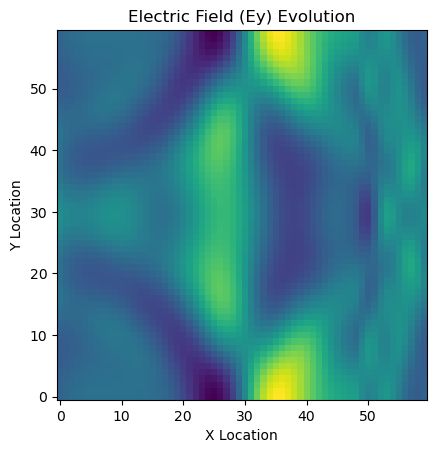

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Select the component index for the electric field, e.g., 0 for Ex, 1 for Ey, etc.
component_index = 1

# Function to update the plot for each frame
def update_plot(frame_number, E_hist, plot):
    plot[0].remove()  # Remove the previous image
    plot[0] = ax.imshow(E_hist[frame_number, component_index, :, :, 0].T, cmap='viridis', origin='lower')
    return plot

# Set up the figure and axis
fig, ax = plt.subplots()
plot = [ax.imshow(E_hist[0, component_index, :, :, 0].T, cmap='viridis', origin='lower')]  # Initial plot
ax.set_title('Electric Field (Ey) Evolution')
ax.set_xlabel('X Location')
ax.set_ylabel('Y Location')

# Creating the animation
ani = FuncAnimation(fig, update_plot, frames=t_steps, fargs=(E_hist, plot), blit=True)

# Save the animation
ani.save('electric_field_evolution.mp4', writer='ffmpeg', fps=120)

plt.show()


## Plot heatmap of X and Y values to ensure accuracy

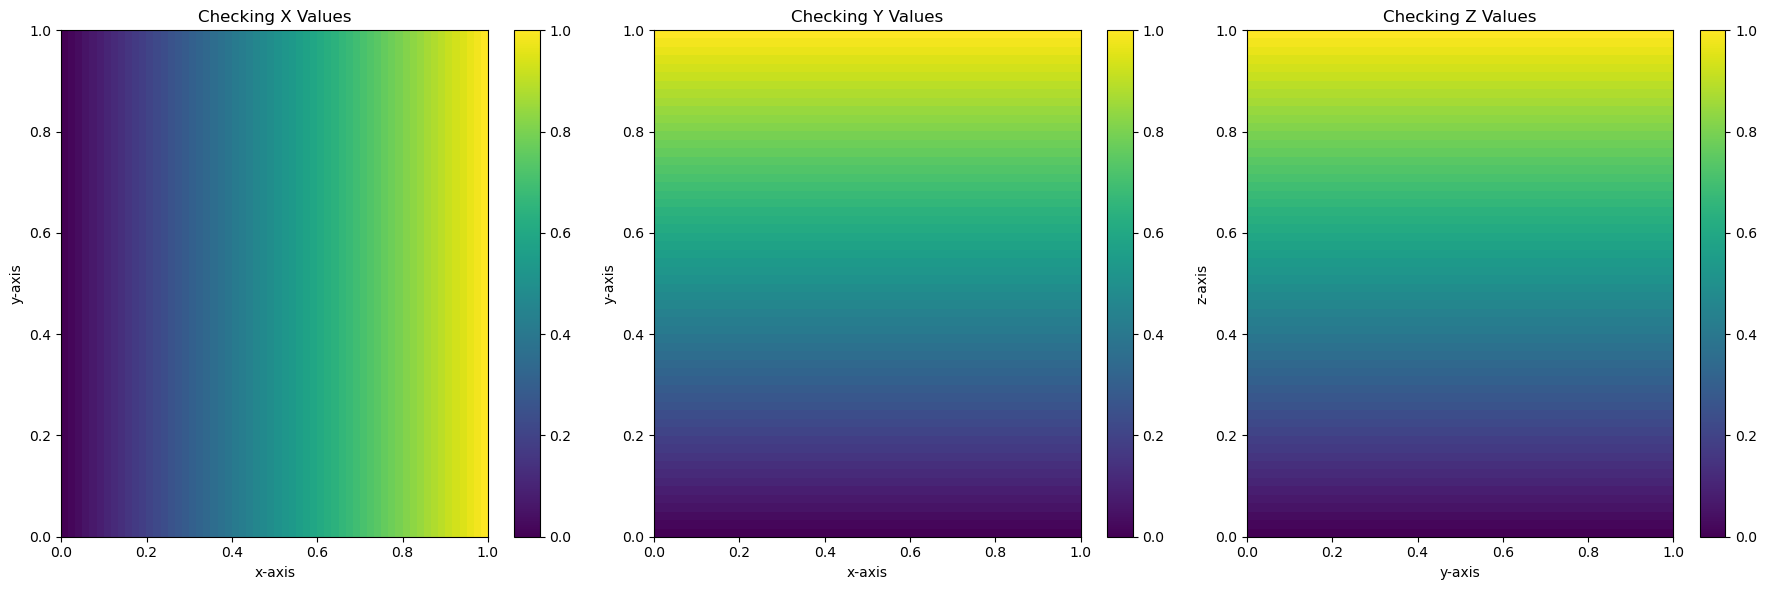

In [11]:
# Plot heatmap of X and Y values to ensure accuracy
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Checking X Values')
plt.imshow(X[:, :, 0].T, extent=(0, 1, 0, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('x-axis')
plt.ylabel('y-axis')

# Plot heatmap of Y values without transposing
plt.subplot(1, 3, 2)
plt.title('Checking Y Values')
plt.imshow(Y[:, :, 0].T, extent=(0, 1, 0, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('x-axis')
plt.ylabel('y-axis')

# Plot heatmap of Y values without transposing
plt.subplot(1, 3, 3)
plt.title('Checking Z Values')
plt.imshow(Z[0, :, :].T, extent=(0, 1, 0, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('y-axis')
plt.ylabel('z-axis')

plt.tight_layout()
plt.show()

# Plot material properties at Z=0 slice

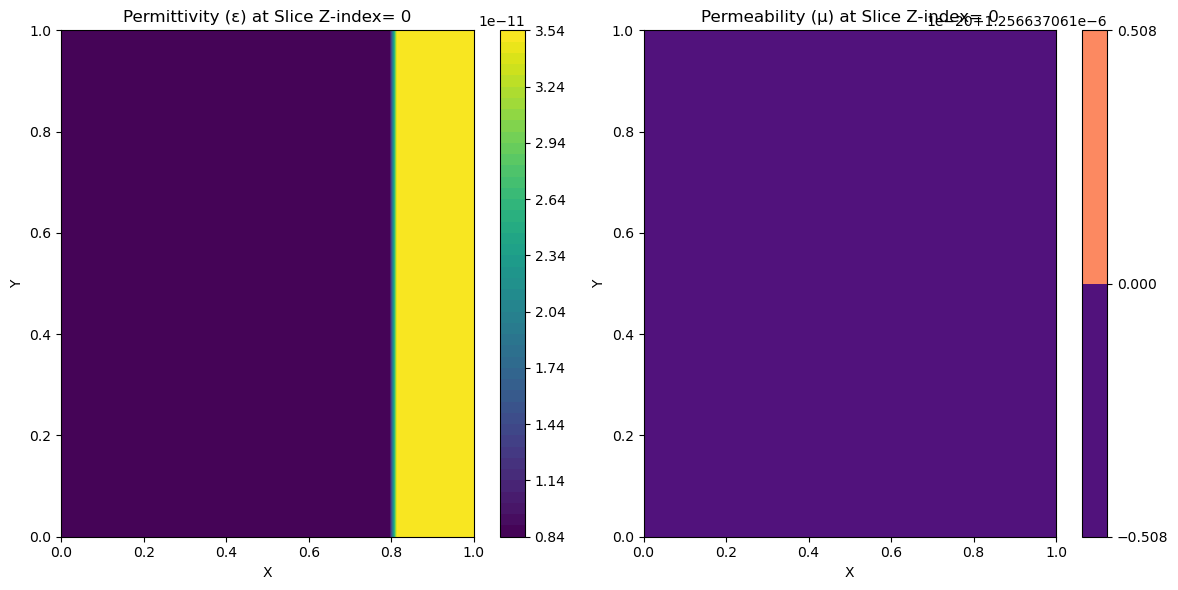

In [12]:
plot_material_properties(X, Y, epsilon, mu, slice_index=0)

## Check Courant-Friedrichs-Lewy (CFL) condition:

In [13]:
c=3*10**8
print(delta_t <= dx/c)

True


In [14]:
print(f"delta_t:{delta_t}")
print(f"delta_t:{dx/c}")

delta_t:1.6666666666666668e-12
delta_t:5.5555555555555553e-11
